# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,}'.format

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Cleaning and Merging the data

In [2]:
print(portfolio.shape)
portfolio.head()

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
print(profile.shape)
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,nan
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,"112,000.0"
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,nan
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,"100,000.0"
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,nan


In [4]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
# Cleaning transcript data
transcript['value_key'] = transcript['value'].apply(lambda x:list(x.keys())[0])
transcript['value_key'] = transcript['value_key'].apply(lambda x:x.replace(' ', '_'))
transcript['value_values'] = transcript['value'].apply(lambda x:list(x.values())[0])

transcript = transcript.drop(['value'], axis=1)
transcript.head()

,event,person,time,value_key,value_values
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer_id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer_id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0


### Creating a master dataset

In [6]:
data = transcript.merge(profile, how = 'left', left_on = 'person', right_on = 'id').drop(['id'], axis=1)
data = data.merge(portfolio, how = 'left', left_on = 'value_values', right_on = 'id').drop(['id'], axis=1)
print(data.shape)
data.head()

(306534, 14)


,event,person,time,value_key,value_values,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer_id,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,2017-05-09,F,"100,000.0","[web, email, mobile]",5.0,7.0,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,2017-08-04,None,nan,"[web, email]",20.0,10.0,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer_id,2906b810c7d4411798c6938adc9daaa5,68,2018-04-26,M,"70,000.0","[web, email, mobile]",10.0,7.0,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer_id,fafdcd668e3743c1bb461111dcafc2a4,118,2017-09-25,None,nan,"[web, email, mobile, social]",10.0,10.0,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer_id,4d5c57ea9a6940dd891ad53e9dbe8da0,118,2017-10-02,None,nan,"[web, email, mobile, social]",10.0,5.0,bogo,10.0


## Understanding the data

In [7]:
# Distinct type of events
data.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [8]:
# Distinct type of transaction information
data.value_key.value_counts()

offer_id    167581
amount      138953
Name: value_key, dtype: int64

### Understanding the membership enrollment trends

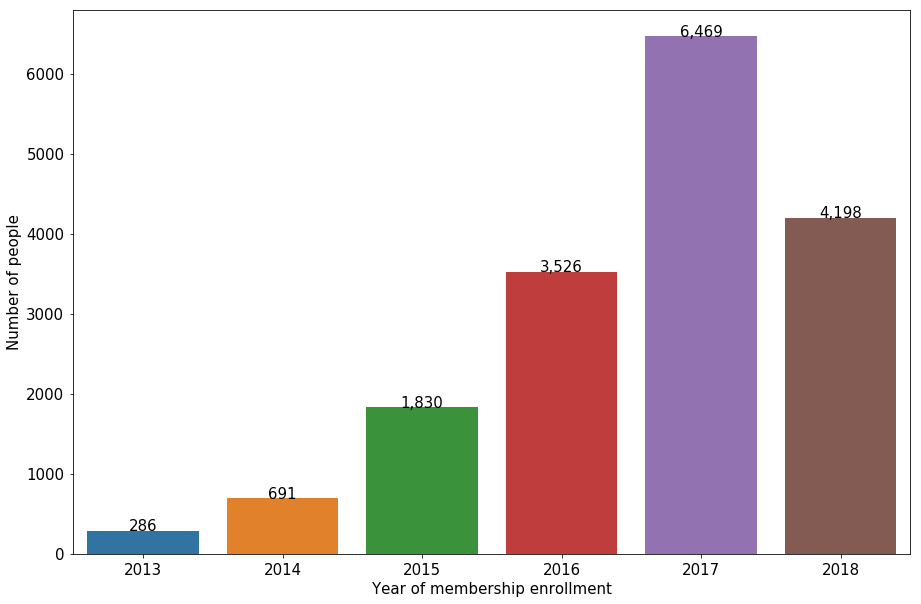

In [32]:
# Create a column to hold the membership enrollment year and calculate number of enrollments by year
data['became_member_on_year'] = data['became_member_on'].dt.year
data1 = data.groupby(['became_member_on_year'])['person'].nunique().reset_index()
data1.columns = ['Year of membership enrollment', 'Number of people']
sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15})   
plt.figure(figsize = (15,10))
g = sns.barplot(x = 'Year of membership enrollment', y = 'Number of people', data=data1)
for index, row in data1.iterrows():
    g.text(row.name,row['Number of people'], '{:,}'.format(round(row['Number of people'],1)), color='black', ha="center",fontdict = {'size':15})

plt.show()

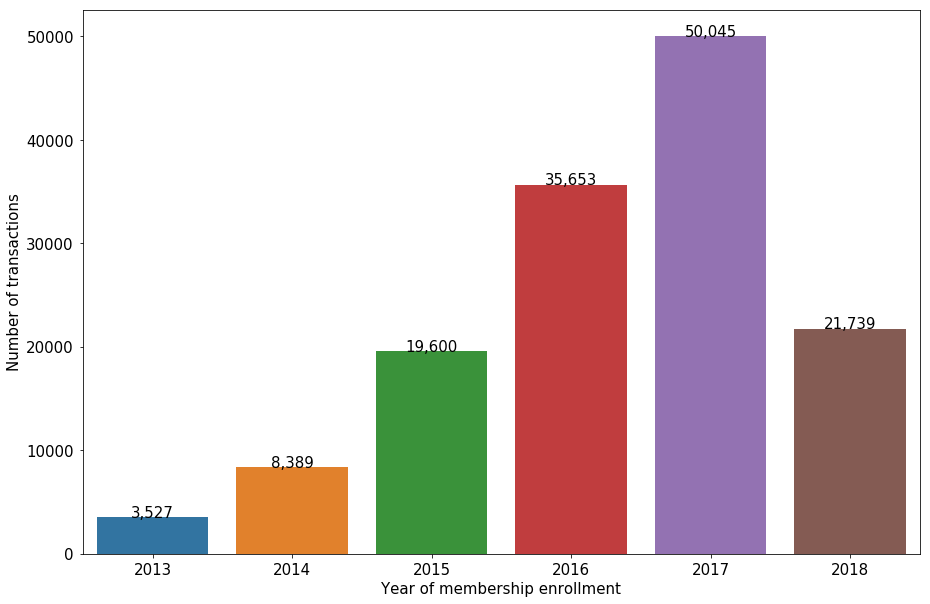

In [31]:
# Create a column to hold the membership enrollment year and calculate number of transactions by the members enrolled in that year
data['became_member_on_year'] = data['became_member_on'].dt.year
data1 = data[data['event']=='transaction'].groupby(['became_member_on_year'])['person'].count().reset_index()
data1.columns = ['Year of membership enrollment', 'Number of transactions']
sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15})   
plt.figure(figsize = (15,10))
g = sns.barplot(x = 'Year of membership enrollment', y = 'Number of transactions', data=data1)
for index, row in data1.iterrows():
    g.text(row.name,row['Number of transactions'], '{:,}'.format(round(row['Number of transactions'],1)), color='black', ha="center",fontdict = {'size':15})

plt.show()

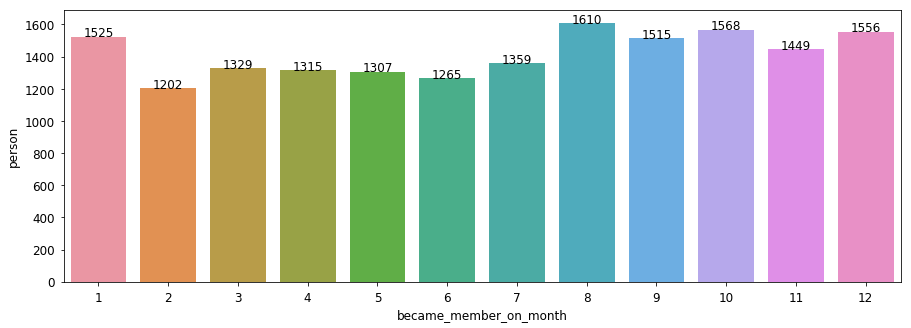

In [10]:
# Create a column to hold the membership enrollment month and calculate number of enrollments by month
data['became_member_on_month'] = data['became_member_on'].dt.month
data1 = data.groupby(['became_member_on_month'])['person'].nunique().reset_index()

sns.set_context("paper", rc={"font.size":12, "xtick.labelsize":12, "ytick.labelsize":12,"axes.labelsize":12})   
plt.figure(figsize = (15,5))
g = sns.barplot(x = 'became_member_on_month', y = 'person', data=data1)
for index, row in data1.iterrows():
    g.text(row.name,row['person'], round(row['person'],1), color='black', ha="center",fontdict = {'size':12})

plt.show()

In [11]:
# Exact timeframe of the enrollment window
data1 = data[['person','became_member_on']].drop_duplicates()
data1['became_member_on'].min(), data1['became_member_on'].max()

(Timestamp('2013-07-29 00:00:00'), Timestamp('2018-07-26 00:00:00'))

### Classifying the members based on the offer event

In [12]:
person_withoffer = list(data.loc[data['event'] == 'offer received','person'].unique())
person_withoutoffer = list(set(data['person']) - set(person_withoffer))

print("Number of people that have received the offer: ", len(person_withoffer))
print("Number of people that have not received the offer: ", len(person_withoutoffer))

Number of people that have received the offer:  16994
Number of people that have not received the offer:  6


In [13]:
person_viewoffer = list(data.loc[data['event'] == 'offer viewed','person'].unique())
person_completedoffer = list(data.loc[data['event'] == 'offer completed','person'].unique())
person_both_vandc = list(set(person_viewoffer).intersection(set(person_completedoffer)))
person_onlyviewoffer = list(set(person_viewoffer) - set(person_completedoffer))
person_directcompleted = list(set(person_completedoffer) - set(person_viewoffer))
person_noaction = list(set(person_withoffer) - set(person_viewoffer) - set(person_completedoffer))

print("Number of people that have viewed the offer: ", len(person_viewoffer))
print("  Number of people that have viewed and completed the offer: ", len(person_both_vandc))
print("  Number of people that have viewed the offer but did not complete: ", len(person_onlyviewoffer))
print("\n")
print("Number of people that have completed the offer: ", len(person_completedoffer))
print("  Number of people that have completed the offer without seeing it: ", len(person_directcompleted))
print("\n")
print("Number of people that have not taken any action: ", len(person_noaction))

Number of people that have viewed the offer:  16834
  Number of people that have viewed and completed the offer:  12701
  Number of people that have viewed the offer but did not complete:  4133


Number of people that have completed the offer:  12774
  Number of people that have completed the offer without seeing it:  73


Number of people that have not taken any action:  87


In [14]:
# Creating a master customer list with their offer status appended as a column
person_list1 = pd.DataFrame(person_withoutoffer, columns = ['person'])
person_list1['Offer status'] = 'Did not receive'

person_list2 = pd.DataFrame(person_both_vandc, columns = ['person'])
person_list2['Offer status'] = 'Viewed and Completed'

person_list3 = pd.DataFrame(person_noaction, columns = ['person'])
person_list3['Offer status'] = 'Did not act'

person_list4 = pd.DataFrame(person_onlyviewoffer, columns = ['person'])
person_list4['Offer status'] = 'Viewed but did not complete'

person_list5 = pd.DataFrame(person_directcompleted, columns = ['person'])
person_list5['Offer status'] = 'Did not view but completed'

person_list = pd.concat([person_list1, person_list2, person_list3, person_list4, person_list5], axis=0)
print(person_list.shape)
person_list.head()

(17000, 2)


,person,Offer status
0,12ede229379747bd8d74ccdc20097ca3,Did not receive
1,3a4874d8f0ef42b9a1b72294902afea9,Did not receive
2,c6e579c6821c41d1a7a6a9cf936e91bb,Did not receive
3,da7a7c0dcfcb41a8acc7864a53cf60fb,Did not receive
4,ae8111e7e8cd4b60a8d35c42c1110555,Did not receive


### Calculating average amount spent by different user groups by their offer status

In [44]:
person_avg = data.loc[data['value_key'] == 'amount',['person','value_values']].copy().reset_index(drop=True)
person_avg['value_values'] = person_avg['value_values'].astype('float')
person_avg = person_avg.groupby(['person'])['value_values'].agg({'value_values':['sum', 'count']}).reset_index()
person_avg.columns = ['person','total_spend', 'num_instances']
person_avg = person_list.merge(person_avg, how = 'left', on =['person'])
person_avg = person_avg.groupby(['Offer status']).agg({'total_spend':'sum', 'num_instances':'sum', 'person':'count'}).reset_index()
person_avg['Average spend'] = person_avg['total_spend']/person_avg['num_instances']
person_avg['sortorder'] = [5,1,4,2,3]
person_avg = person_avg.sort_values('sortorder').reset_index(drop = True)
person_avg.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,Offer status,total_spend,num_instances,person,Average spend,sortorder
0,Did not receive,250.60999999999999,20.0,6,12.5305,1
1,Viewed and Completed,"1,693,007.7099999958","117,847.0",12701,14.366150262628627,2
2,Viewed but did not complete,"74,668.57999999975","20,476.0",4133,3.6466389919906113,3
3,Did not view but completed,"6,210.930000000001",331.0,73,18.764138972809672,4
4,Did not act,"1,314.14",279.0,87,4.710179211469534,5


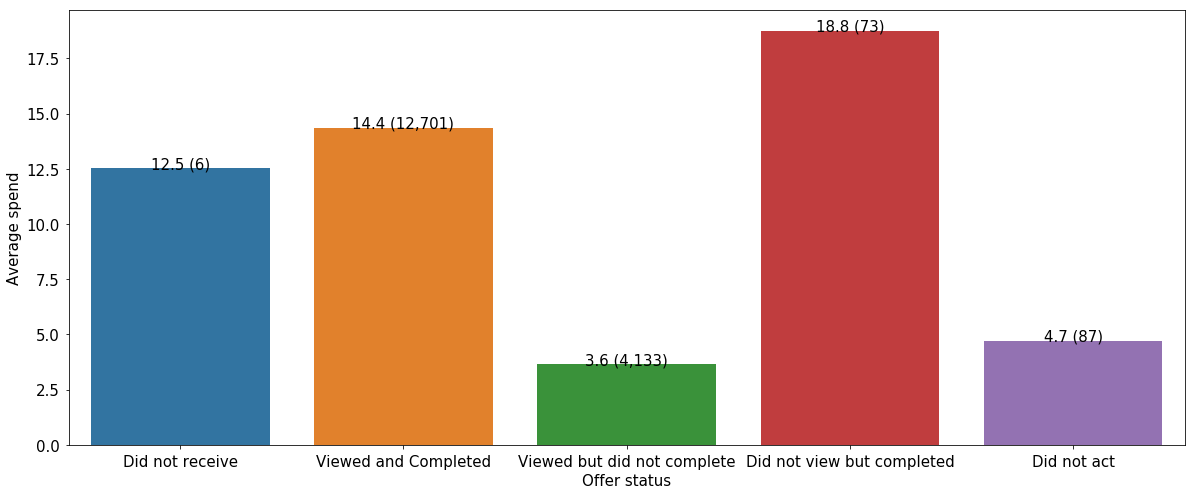

In [46]:
sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15})   
plt.figure(figsize = (20,8))
g = sns.barplot(x = 'Offer status', y = 'Average spend', data=person_avg)
for index, row in person_avg.iterrows():
    g.text(row.name,row['Average spend'], str(round(row['Average spend'],1))+' ('+'{:,}'.format(row['person'])+')', color='black', ha="center",fontdict = {'size':15})

plt.show()

In [48]:
person_list['Offer status'].value_counts()

Viewed and Completed           12701
Viewed but did not complete     4133
Did not act                       87
Did not view but completed        73
Did not receive                    6
Name: Offer status, dtype: int64

### Analyze the different offers and their impact on spend

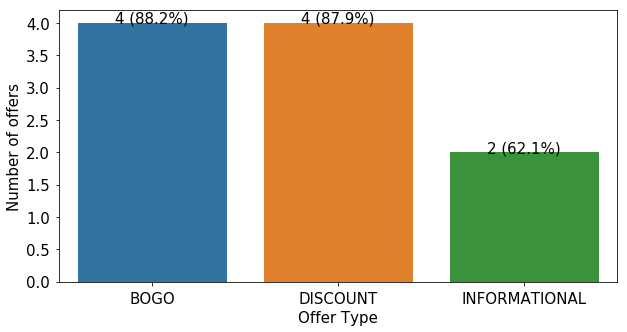

In [61]:
# Identifying the number of people that have received each type of offer
data2 = data.loc[data['value_key']!= 'amount', ['offer_type', 'person']].drop_duplicates()
data2 = data2.groupby(['offer_type'])['person'].nunique().reset_index()
data2.columns = ['Offer Type', 'perc']
data2['Offer Type'] = data2['Offer Type'].str.upper()
data2['perc'] = (100*data2['perc'])/16994

# Identifying the number of distinct offers by their offer type
data3 = data.loc[data['value_key']!= 'amount', ['offer_type', 'value_values']].drop_duplicates()
data3 = data3.groupby(['offer_type'])['value_values'].nunique().reset_index()
data3.columns = ['Offer Type', 'Number of offers']
data3['Offer Type'] = data3['Offer Type'].str.upper()
data3 = data3.merge(data2, how = 'left', on = ['Offer Type'])

sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15})   
plt.figure(figsize = (10,5))
g = sns.barplot(x = 'Offer Type', y = 'Number of offers', data=data3)
for index, row in data3.iterrows():
    g.text(row.name,row['Number of offers'], str(round(row['Number of offers'],1))+' ('+str(round(row['perc'],1))+'%)', color='black', ha="center",fontdict = {'size':15})

plt.show()

In [103]:
# Flagging the customer exposure to different type of offers
data4 = data.loc[data['value_key']!= 'amount', ['person', 'offer_type', 'value_key']].drop_duplicates()
data4 = data4.groupby(['person', 'offer_type'])['value_key'].count().unstack(['offer_type']).fillna(0).reset_index()
data41 = data4.groupby(['bogo', 'discount', 'informational'])['person'].nunique().reset_index()
data41

,bogo,discount,informational,person
0,0.0,0.0,1.0,66
1,0.0,1.0,0.0,466
2,0.0,1.0,1.0,1470
3,1.0,0.0,0.0,487
4,1.0,0.0,1.0,1496
5,1.0,1.0,0.0,5494
6,1.0,1.0,1.0,7515


In [139]:
7515/16994, (487)/16994, (466)/16994, 66/16994

(0.4422148993762504,
 0.02865717311992468,
 0.027421442862186653,
 0.0038837236671766507)

In [106]:
# Calculating the time of completion of different offers experienced by the customer to analyze their spending pattern
data5 = data.loc[data['event'] == 'offer viewed', ['person', 'offer_type', 'time']].drop_duplicates()
data5 = data5.groupby(['person', 'offer_type'])['time'].max().unstack(['offer_type']).fillna(0).reset_index()
print(data5.shape)
data5.head()

(16834, 4)


offer_type,person,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,456.0,540.0,372.0
1,00116118485d4dfda04fdbaba9a87b5c,630.0,0.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,516.0,432.0,354.0
3,0020c2b971eb4e9188eac86d93036a77,426.0,12.0,660.0
4,0020ccbbb6d84e358d3414a3ff76cffd,582.0,168.0,408.0


In [107]:
# Calculating the average spend of the customers before viewing the offer
data6 = data[data['value_key']=='amount'].merge(data5, how = 'left', on =['person'])
data6 = data6[(data6['time'] <= data6['bogo'])]
data6['value_values'] = data6['value_values'].astype('float')
data6 = data6.groupby(['person']).agg({'value_values':['sum', 'count']}).reset_index()
data6.columns = ['person', 'prebogo_sum', 'prebogo_count']

data7 = data4.merge(data6, how ='left', on = ['person'])

data6 = data[data['value_key']=='amount'].merge(data5, how = 'left', on =['person'])
data6 = data6[(data6['time'] <= data6['bogo'])]
data6['value_values'] = data6['value_values'].astype('float')
data6 = data6.groupby(['person']).agg({'value_values':['sum', 'count']}).reset_index()
data6.columns = ['person', 'predisc_sum', 'predisc_count']

data7 = data7.merge(data6, how ='left', on = ['person'])
data71 = data7.drop(['person'],axis=1).groupby(['bogo', 'discount', 'informational']).sum().reset_index()
data71['prebogo_avg'] = data71['prebogo_sum']/data71['prebogo_count']
data71['predisc_avg'] = data71['predisc_sum']/data71['predisc_count']
data71 = data71.drop(['prebogo_sum', 'prebogo_count', 'predisc_count', 'predisc_sum'], axis=1)
data71

,bogo,discount,informational,prebogo_avg,predisc_avg
0,0.0,0.0,1.0,18.6,18.6
1,0.0,1.0,0.0,11.069166666666666,11.069166666666666
2,0.0,1.0,1.0,12.695714285714283,12.695714285714283
3,1.0,0.0,0.0,12.584397515527954,12.584397515527954
4,1.0,0.0,1.0,13.62926705478431,13.62926705478431
5,1.0,1.0,0.0,12.6897526633391,12.6897526633391
6,1.0,1.0,1.0,12.75885052350189,12.75885052350189


In [108]:
# Calculating the average spend of the customers after viewing the offer
data6 = data[data['value_key']=='amount'].merge(data5, how = 'left', on =['person'])
data6 = data6[(data6['time'] > data6['bogo'])&(data6['bogo']>0)]
data6['value_values'] = data6['value_values'].astype('float')
data6 = data6.groupby(['person']).agg({'value_values':['sum', 'count']}).reset_index()
data6.columns = ['person', 'postbogo_sum', 'postbogo_count']

data8 = data4.merge(data6, how ='left', on = ['person'])

data6 = data[data['value_key']=='amount'].merge(data5, how = 'left', on =['person'])
data6 = data6[(data6['time'] > data6['bogo'])&(data6['discount']>0)]
data6['value_values'] = data6['value_values'].astype('float')
data6 = data6.groupby(['person']).agg({'value_values':['sum', 'count']}).reset_index()
data6.columns = ['person', 'postdisc_sum', 'postdisc_count']

data8 = data8.merge(data6, how ='left', on = ['person'])
data81 = data8.drop(['person'],axis=1).groupby(['bogo', 'discount', 'informational']).sum().reset_index()
data81['postbogo_avg'] = data81['postbogo_sum']/data81['postbogo_count']
data81['postdisc_avg'] = data81['postdisc_sum']/data81['postdisc_count']
data81 = data81.drop(['postbogo_sum', 'postbogo_count', 'postdisc_count', 'postdisc_sum'], axis=1)
data81

,bogo,discount,informational,postbogo_avg,postdisc_avg
0,0.0,0.0,1.0,nan,nan
1,0.0,1.0,0.0,nan,12.588167569108007
2,0.0,1.0,1.0,nan,12.74714494163423
3,1.0,0.0,0.0,12.058105536332189,nan
4,1.0,0.0,1.0,12.756149410879907,nan
5,1.0,1.0,0.0,13.0224993028055,13.33356436196972
6,1.0,1.0,1.0,12.63810614149565,13.051367090601271


In [122]:
data9 = data41.merge(data71, how = 'left', on = ['bogo', 'discount', 'informational'])
data9 = data9.merge(data81, how = 'left', on = ['bogo', 'discount', 'informational'])
data9

,bogo,discount,informational,person,prebogo_avg,predisc_avg,postbogo_avg,postdisc_avg
0,0.0,0.0,1.0,66,18.6,18.6,nan,nan
1,0.0,1.0,0.0,466,11.069166666666666,11.069166666666666,nan,12.588167569108007
2,0.0,1.0,1.0,1470,12.695714285714283,12.695714285714283,nan,12.74714494163423
3,1.0,0.0,0.0,487,12.584397515527954,12.584397515527954,12.058105536332189,nan
4,1.0,0.0,1.0,1496,13.62926705478431,13.62926705478431,12.756149410879907,nan
5,1.0,1.0,0.0,5494,12.6897526633391,12.6897526633391,13.0224993028055,13.33356436196972
6,1.0,1.0,1.0,7515,12.75885052350189,12.75885052350189,12.63810614149565,13.051367090601271


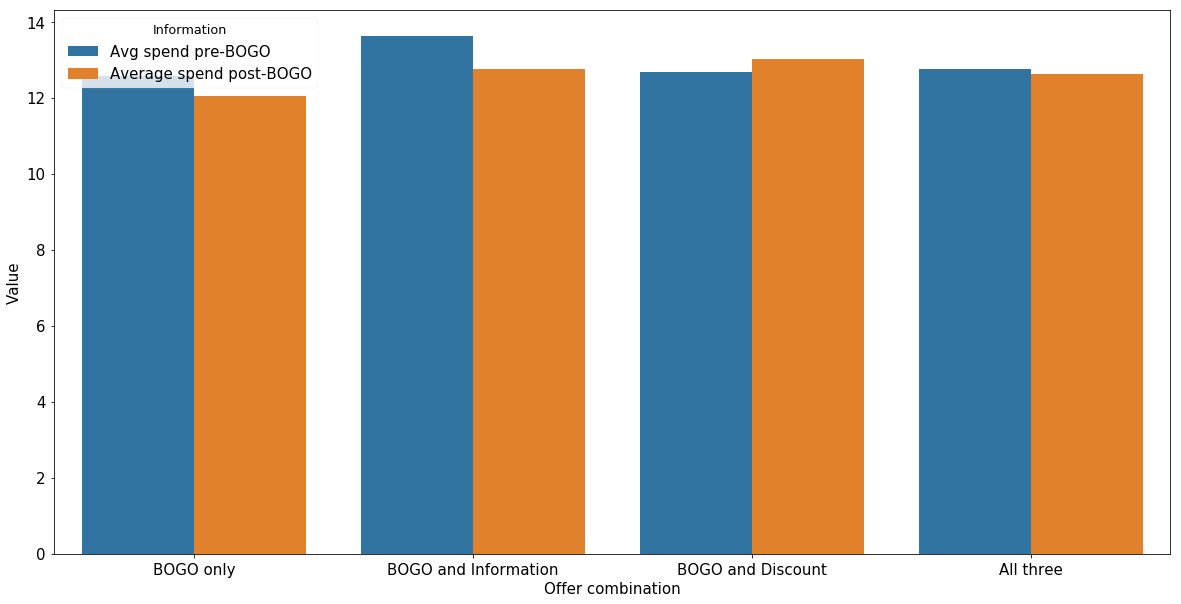

In [130]:
# Plot the spend change in customers due to different offer combinations
data9 = data41.merge(data71, how = 'left', on = ['bogo', 'discount', 'informational'])
data9 = data9.merge(data81, how = 'left', on = ['bogo', 'discount', 'informational'])
data9 = data9.rename(columns = {'prebogo_avg':'Avg spend pre-BOGO', 'postbogo_avg':'Average spend post-BOGO', 'predisc_avg':'Avg spend pre-Discount', 'postdisc_avg':'Average spend post-Discount'})
data9['Offer combination'] = ['Information only', 'Discount only', 'Discount and Information', 'BOGO only', 
                              'BOGO and Information', 'BOGO and Discount', 'All three']
data9.index = data9['Offer combination']
data9 = data9.drop(['informational', 'bogo', 'discount','Offer combination', 'person'], axis=1).stack().reset_index()
data9.columns = ['Offer combination', 'Information', 'Value']

data91 = data9[(data9['Offer combination'].isin(['BOGO only','BOGO and Information', 'BOGO and Discount', 'All three']))&(['BOGO' in i for i in data9['Information']])]
sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15, "legend.fontsize":15})   
plt.figure(figsize = (20,10))
g = sns.barplot(x='Offer combination', y = 'Value', hue = 'Information', data = data91)
# for index, row in data91.iterrows():
#     g.text(row.name,row['Value'], round(row['Value'],1), color='black', ha="center",fontdict = {'size':15})

plt.show()

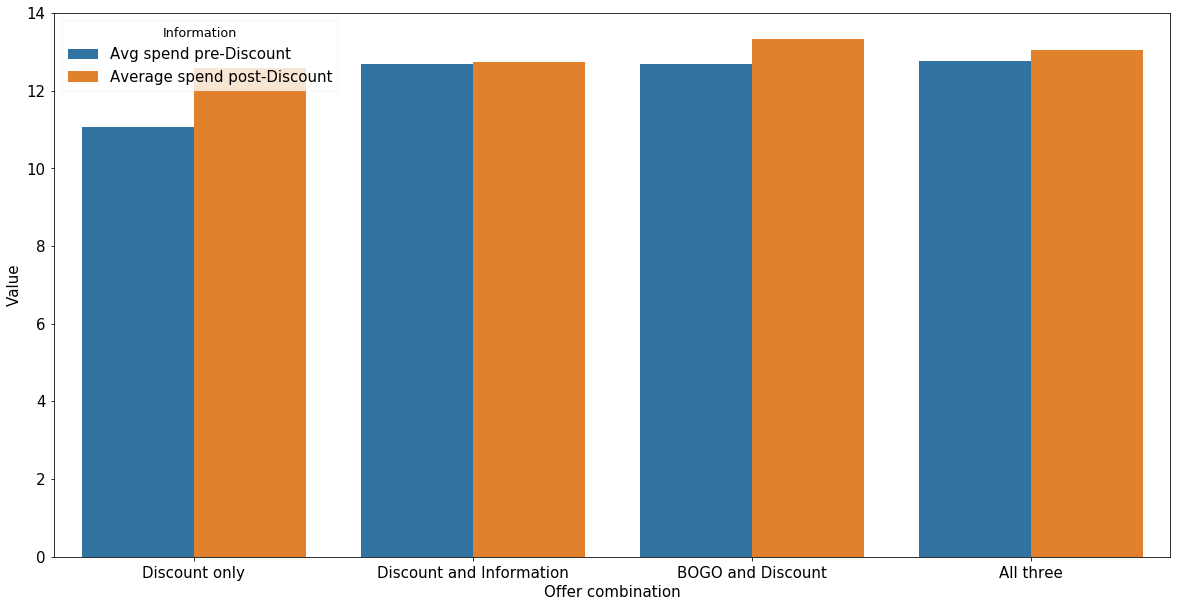

In [131]:
data91 = data9[(data9['Offer combination'].isin(['Discount only','Discount and Information', 'BOGO and Discount', 'All three']))&(['Discount' in i for i in data9['Information']])]
sns.set_context("paper", rc={"font.size":15, "xtick.labelsize":15, "ytick.labelsize":15,"axes.labelsize":15, "legend.fontsize":15})   
plt.figure(figsize = (20,10))
g = sns.barplot(x='Offer combination', y = 'Value', hue = 'Information', data = data91)
# for index, row in data91.iterrows():
#     g.text(row.name,row['Value'], round(row['Value'],1), color='black', ha="center",fontdict = {'size':15})

plt.show()